# import libraries

In [7]:
#--- system libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from scipy.interpolate import Rbf
import random as rand
import pdb 
import sys
#
matplotlib.rcParams['text.usetex'] = True
warnings.filterwarnings('ignore')
#

#--- user modules
import LammpsPostProcess as lp

# Parameters

In [8]:
path = '/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/testRuns/test2nd/Run0' #--- comment if passed by argument
dumpFile = ('virialStress.xyz','junk.xyz')[0]#--- parse cords

sxyColmn = 'c_1[1]'
muColmn = 'c_1[7]'


In [9]:
def ReturnIndxModulus(arg):
    sdict={'xxxx':0,'xxyy':1, 'xxzz':2, 'xxxy':3, 'xxxz':4, 'xxyz':5,
           'yyxx':1,'yyyy':6, 'yyzz':7, 'yyxy':8, 'yyxz':9, 'yyyz':10,
           'zzxx':2,'zzyy':7, 'zzzz':11,'zzxy':12,'zzxz':13,'zzyz':14,
           'xyxx':3,'xyyy':8, 'xyzz':12,'xyxy':15,'xyxz':16,'xyyz':17,
           'xzxx':4,'xzyy':9, 'xzzz':13,'xzxy':16,'xzxz':18,'xzyz':19,
           'yzxx':5,'yzyy':10,'yzzz':14,'yzxy':17,'yzxz':19,'yzyz':20}
    return sdict[arg]+6+1

def ReturnIndxStress(arg):
    sdict={'xx':0,'xy':3,'xz':4,
           'yx':3,'yy':1,'yz':5,
           'zx':4,'zy':5,'zz':2}
    return sdict[arg]+1

print ReturnIndxStress('xx') #--- stress
print ReturnIndxModulus('xxxx') #--- modulus


1
7


# input stress file

In [336]:
def GetOrthogonalBasis( CellVector ): 
    a0 = CellVector[:,0]
    l0 = np.dot(a0,a0)**0.5
    n0 = a0 / l0 
    #
    a1 = CellVector[:,1]
    a1_perp = a1 - np.dot( a1, n0 ) * n0
    l1 = np.dot( a1_perp, a1_perp) ** 0.5
    #
    a2 = CellVector[:,2]
    l2 = np.dot(a2,a2)**0.5
    
    return np.c_[a0, a1_perp, a2], [l0, l1, l2]


lmpData = lp.ReadDumpFile( '%s/%s'%(path, dumpFile ) )
lmpData.GetCords( ncount = sys.maxint )


# stress-strain curve

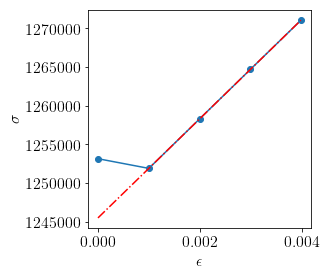

In [337]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
#ax2 = ax.twinx()
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\sigma$',fontsize=16)
ax.tick_params(labelsize=16)
#ax.set_yscale('log')
#ax.set_ylim(1e6,1e8)
#ax2.tick_params(labelsize=16)
#ax.set_title(fileNamee[:-4])
#
#ax.plot(stress[:,0],stress[:,1],'-')

#--- point corresponding to strain maps
virial = []
mu = []
strain = []
times = lmpData.coord_atoms_broken.keys()
times.sort()

box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

for itime in times:
    
    #--- extract atom and box properties
    #
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
    box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))


    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    virial += [np.c_[lmpData.coord_atoms_broken[itime][sxyColmn]].astype(float).sum() / volume]
    mu += [np.c_[lmpData.coord_atoms_broken[itime][muColmn]].astype(float).sum() / volume]
    #--- strain
    if sxyColmn == 'c_1[1]':
        dx=box.CellVector[0,0]-box0.CellVector[0,0]
        l1=box.CellVector[0,0]
        strain += [dx/l1]
    #
    if sxyColmn == 'c_1[2]':
        dy=box.CellVector[1,1]-box0.CellVector[1,1]
        l2=box.CellVector[1,1]
        strain += [dy/l2]
    #
    if sxyColmn == 'c_1[4]':
        dx=box.CellVector[0,1]-box.CellVector[0,1]
        l1=box.CellVector[1,1]
        strain += [dx/l1]

#--- plot stress
ax.plot(np.array(strain),np.array(virial),'-o')

#--- fit
coeffs = np.polyfit(np.array(strain)[1:],np.array(virial)[1:], 1)
def func(x, m, b):
    return m*x+b

#--- print fit
ax.plot(np.array(strain),func(np.array(strain), *coeffs),'-.r')

#
plt.savefig('stressStrain.png',dpi=75,bbox_inches='tight')
plt.show()

# Born Modulus

## Bulk value

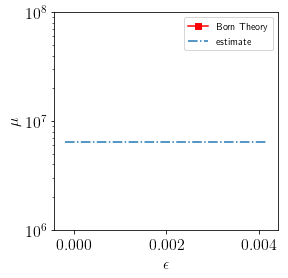

In [338]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
#ax2 = ax.twinx()
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\mu$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_yscale('log')
ax.set_ylim(1e6,1e8)
#ax.set_ylim(1e2,1e3)
#ax.set_ylim(1e0,1e2)
#ax.set_ylim(1e2,1e3)
#ax.set_ylim(1e5,1e7)
#ax2.tick_params(labelsize=16)
#ax.set_title(fileNamee[:-4])
#
#ax.plot(stress[:,0],stress[:,1],'-')

#--- plot mu
ax.plot(np.array(strain),abs(np.array(mu)),'-rs', label='Born Theory')

#--- plot stress
#ax.plot(2*np.array(strain),np.array(virial),'-o')
#ax.plot(2*np.array(strain),np.gradient(virial,2*np.array(strain)),'-o')
ax.plot(ax.axis()[:2],[ abs(coeffs[0]), abs(coeffs[0]) ],'-.', label='estimate')
#
ax.legend()
#
plt.savefig('bornModulus.png',dpi=75,bbox_inches='tight')
plt.show()

In [335]:
coeffs[0]/np.array(mu)

array([-0.02249834, -0.02252084, -0.02248701, -0.0224516 , -0.02241475])

In [26]:
def dfcut(xi):
    if (xi >= 1.0):
        dfc = 0.0;
        ddfc = 0.0;
        return 1.0,dfc,ddfc;
    elif (xi <= 0.0):
        dfc = 0.0;
        ddfc = 0.0;
        return 0.0,dfc,ddfc;
    else:
        a = 1.0 - xi;
        a3 = a * a * a;
        a4 = a * a3;
        a1m4 = 1.0-a4;

        dfc = 8 * a1m4 * a3;
        ddfc = 8*(-3*a*a*a1m4+4*a3*a3);
        return a1m4*a1m4,dfc,ddfc;




n=100
rij=np.linspace(0,1,n)
dr = 0.5
drinv = 1/dr
rc=1.0

fcij=np.zeros(n)
dfcij=np.zeros(n)
ddfcij=np.zeros(n)
for rr,indx in zip(rij,xrange(sys.maxint)):
    rnorm = (rc-rr)/dr
    fc,dfc, ddfc = dfcut(rnorm );
    fcij[indx] = fc;
    dfcij[indx] = dfc * drinv; 
    ddfcij[indx] = ddfc * drinv * drinv; 



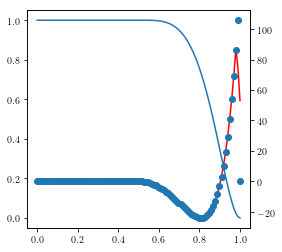

In [46]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax2=ax.twinx()

ax.plot(rij,fcij)
#ax2.plot(rij,np.gradient(fcij,rij),'r')
#ax2.plot(rij,-dfcij,'o')
ax2.plot(rij,np.gradient(np.gradient(fcij,rij),rij),'r')
ax2.plot(rij,ddfcij,'o')
plt.show()

In [292]:
def dCfunc(rij2, rik2, rjk2):

    rij4 = rij2 * rij2;
    a = rik2 - rjk2;
    b = rik2 + rjk2;
    asq = a*a;
    denom = rij4 - asq;
    denom = denom * denom;
    return -4 * (-2 * rij2 * asq + rij4 * b + asq * b) / denom


def ddCfunc(rij,  rij2,  rik2, rjk2):

    rij4 = rij2 * rij2;
    rij3 = rij2 * rij;
    a = rik2 - rjk2;
    b = rik2 + rjk2;
    asq = a*a;
    denom = rij4 - asq;
    denom = denom * denom;
    ddenom = 2*(rij4-asq)*(4*rij3);

    dcikj = dCfunc(rij2, rik2, rjk2);
    ddcikj = -4 * (-2 * 2 * rij * asq + 4*rij3 * b ) - dcikj * ddenom;
    ddcikj /= denom;

    return ddcikj * rij+dcikj;    


def fcut(xi):
    if xi >= 1.0:
      return 1.0;
    elif xi <= 0.0:
      return 0.0;
    else:
      a = 1.0 - xi;
      a *= a; a *= a;
      a = 1.0 - a;
      return a * a;
      


n=1000
cikj = np.zeros(n)
dCikj = np.zeros(n)
ddCikj = np.zeros(n)
DSIJ = np.zeros(n)
DDSIJ = np.zeros(n)
fcij=np.zeros(n)
dfcij=np.zeros(n)
ddfcij=np.zeros(n)
xx=np.linspace(0.1,1,n) 
dfikj=np.linspace(0.1,1,n) 
ddfikj=np.linspace(0.1,1,n) 
Cmax=1.0e2
Cmin=0.0001
rc=1.0
dscrfcn = np.zeros(n)
ddscrfcn = np.zeros(n)
SIJ = np.zeros(n)
dr = 0.5
drinv = 1/dr


for xitem,indx in zip(xx,xrange(sys.maxint)):
    sij = 1.0;

    rij = xitem
    
    rnorm = (rc-rij)/dr
    fc,dfc, ddfc = dfcut(rnorm );
    fcij[indx] = fc;
    dfcij[indx] = dfc * drinv; 
    ddfcij[indx] = ddfc * drinv * drinv; 


        
        
    
    rik = 0.5;rjk=0.5
    rij2 = rij*rij
    rik2 = rik*rik
    rjk2 = rjk*rjk
    xik = rik2 / rij2
    xjk = rjk2 / rij2
    a = 1 - (xik - xjk) * (xik - xjk);
    if a <= 0.0: continue;

    cikj[indx] = (2.0 * (xik + xjk) + a - 2.0) / a; #//--- Eq. (4.11d)

    if (cikj[indx] >= Cmax): 
#        print 'hello'
        continue;
    elif (cikj[indx] <= Cmin): 
        print 'hello'
        sij = 0.0;
        break;
    else:
        delc = Cmax - Cmin;
        cikj[indx] = (cikj[indx] - Cmin) / delc; #//--- func. arg. in Eq.(4.11c)
        sikj = fcut(cikj[indx]); #//--- Eq.(4.11c)
    sij *= sikj
#    print sij, sikj
    
    sikj,dfikj[indx], ddfikj[indx] = dfcut(cikj[indx] );# //--- dfikj is (4.20b), sikj is (4.11c)
    coef1 = dfikj[indx] / (delc * sikj);
    dCikj[indx] = dCfunc(rij2, rik2, rjk2);
    ddCikj[indx] = ddCfunc(rij, rij2, rik2, rjk2);
    dscrfcn[indx] = dscrfcn[indx] + coef1 * dCikj[indx]; #//--- (4.21)/rij: sum over k
    dCikj[indx] *= rij;
    
    arg1_d = (1.0/delc)*( -(dfikj[indx]*dfikj[indx]*dCikj[indx]*dCikj[indx])/delc/sikj/sikj+  #????????????
                            (ddfikj[indx]*dCikj[indx]*dCikj[indx]/sikj/delc) + 
                            (dfikj[indx]*ddCikj[indx]/sikj)  ) ;

#     arg1_d = (1.0/delc)*(  (ddfikj[indx]*dCikj[indx]*dCikj[indx]/delc) + 
#                               (dfikj[indx]*ddCikj[indx])  ) ;
    
#    arg1_d = (1.0/delc)*( (ddCikj[indx])  ) ;
    
        
    jn=indx
    

    sfcij = sij * fcij[indx]; #//--- 4.11a
        
    coef1 = sfcij;
    coef2 = sij * dfcij[indx] / rij; #//--- scaled by rij
    arg1 = dscrfcn[jn] * rij 
#    arg1 = (1.0/delc)*dfikj[indx]*dCikj[indx] #dscrfcn[jn] * rij;
#    arg1 = (1.0/delc)*dCikj[indx] #dscrfcn[jn] * rij;
    dsij = sij * arg1;
    ddsij = dsij * arg1 + sij * arg1_d;
    DSIJ[indx]=dsij 
    DDSIJ[indx]=ddsij 
    
    dscrfcn[indx] = dscrfcn[indx] * coef1 - coef2; #//--- (4.22a)/rij: units of s/r^2
    ddscrfcn[jn] = - drinv * dfc * dsij + fcij[indx] * ddsij - drinv * ( dsij * dfc - sij * ddfc * drinv ); #//--- units of s/r^2

    SIJ[indx]=sfcij

hello


In [293]:
# def dCfunc(rij2, rik2, rjk2):

#     rij4 = rij2 * rij2;
#     a = rik2 - rjk2;
#     b = rik2 + rjk2;
#     asq = a*a;
#     denom = rij4 - asq;
#     denom = denom * denom;
#     return -4 * (-2 * rij2 * asq + rij4 * b + asq * b) / denom


# def ddCfunc(rij,  rij2,  rik2, rjk2):

#     rij4 = rij2 * rij2;
#     rij3 = rij2 * rij;
#     a = rik2 - rjk2;
#     b = rik2 + rjk2;
#     asq = a*a;
#     denom = rij4 - asq;
#     denom = denom * denom;
#     ddenom = 2*(rij4-asq)*(4*rij3);

#     dcikj = dCfunc(rij2, rik2, rjk2);
#     ddcikj = -4 * (-2 * 2 * rij * asq + 4*rij3 * b ) - dcikj * ddenom;
#     ddcikj /= denom;

#     return ddcikj * rij+dcikj;    

# #n=10
# rik2 = 0.1;rjk2 = 0.34
# rij=np.linspace(0.1,1.0,n)

# dCikj=np.zeros(n)
# ddCikj=np.zeros(n)
# for xitem,indx in zip(xx,xrange(sys.maxint)):
#     sij = 1.0;

#     rij = xitem
#     rik = 0.5;rjk=0.5
#     rij2 = rij*rij
#     rik2 = rik*rik
#     rjk2 = rjk*rjk
    
#     dCikj[indx] = dCfunc(rij2, rik2, rjk2)*rij;
#     ddCikj[indx] = ddCfunc(rij, rij2, rik2, rjk2);


    
    
# fig = plt.figure(figsize=(4,4))
# ax = fig.add_subplot(111)
# rij=xx
# #ax.set_xlim(0.5,1)
# ax.plot(rij,np.gradient(dCikj,rij,edge_order=2),'o',color='black')
# ax.plot(rij,ddCikj,'-',color='red')
# ax.legend()
# #ax2.plot(rij,ddfcij,'o')
# plt.show()

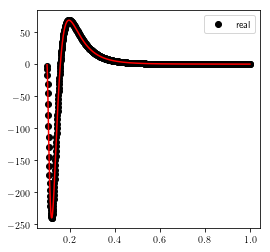

In [297]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#ax2=ax.twinx()

#ax.set_xlim(0.99,1)
#ax.set_ylim(-10,+10)
#ax2.set_xlim(0.8,1)
#ax.set_yscale('log')
#ax2.set_yscale('log')
rij=xx #[:,0]

#ax.plot(rij,DSIJ,'o')

# ax2.plot(rij,np.gradient(SIJ,rij),'ro')
# ax2.plot(rij,dscrfcn*rij,'-')

ax.plot(rij,np.gradient(dscrfcn*rij,rij),'o',label='real',color='black')
ax.plot(rij,ddscrfcn,'-',color='red')
ax.legend()
#ax2.plot(rij,ddfcij,'o')
plt.show()

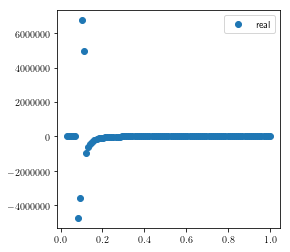

In [208]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#ax2=ax.twinx()

#ax.set_xlim(0.8,1)
#ax.set_ylim(-10,+10)
#ax2.set_xlim(0.8,1)
#ax.set_yscale('log')
#ax2.set_yscale('log')
rij=xx #[:,0]

#ax.plot(rij,DSIJ,'o')

# ax2.plot(rij,np.gradient(SIJ,rij),'ro')
# ax2.plot(rij,dscrfcn*rij,'-')

ax.plot(rij,np.gradient(np.gradient(DSIJ,rij),rij),'o',label='real')
#ax.plot(rij,DDSIJ,'s')
ax.legend()
#ax2.plot(rij,ddfcij,'o')
plt.show()

In [190]:
DDSIJ

array([           nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.76357606e+04, 3.93660000e+04,
       2.77950234e+04, 2.01798819e+04, 1.50030614e+04, 1.13848416e+04,
       8.79451913e+03, 6.90075078e+03, 5.49037500e+03, 4.42259963e+03,
       3.60223504e+03, 2.96356768e+03, 2.46037500e+03, 2.05958957e+03,
       1.73718896e+03, 1.47547547e+03, 1.26124262e+03, 1.08451852e+03,
       9.37691336e+02, 8.14891968e+02, 7.11552600e+02, 6.24087169e+02,
       5.49657446e+02, 4.86000000e+02, 4.31296924e+02, 3.84078371e+02,
       3.43148438e+02, 3.07528332e+02, 2.76412477e+02, 2.49134344e+02,
       2.25139690e+02, 2.03965447e+02, 1.85222980e+02, 1.68584719e+02,
       1.53773437e+02, 1.40553600e+02, 1.28724348e+02, 1.18113788e+02,
       1.08574310e+02, 9.99787514e+01, 9.22172170e+01, 8.51944541e+01,
       7.88276635e+01, 7.30446732e+01, 6.77824074e+01, 6.29856000e+01,
      

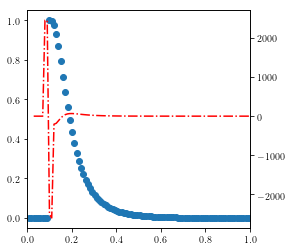

In [142]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax2=ax.twinx()

ax.set_xlim(0.0,1)
ax2.set_xlim(0,1)
#ax.set_yscale('log')
#ax2.set_yscale('log')
rij=xx #[:,0]

ax.plot(rij,SIJ,'o')

# ax2.plot(rij,np.gradient(SIJ,rij),'ro')
# ax2.plot(rij,dscrfcn*rij,'-')

ax2.plot(rij,np.gradient(np.gradient(SIJ,rij),rij),'-.r')
#ax2.plot(rij,ddscrfcn,'-')

#ax2.plot(rij,ddfcij,'o')
plt.show()

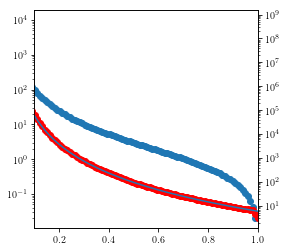

In [98]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax2=ax.twinx()

ax.set_xlim(0.1,1)
ax.set_yscale('log')
ax2.set_yscale('log')
rij=xx #[:,0]

ax.plot(rij,cikj,'o')

#ax2.plot(rij,-np.gradient(cikj,rij),'ro')
#ax2.plot(rij,-dCikj*rij,'-')

ax2.plot(rij,np.gradient(np.gradient(cikj,rij),rij),'ro')
ax2.plot(rij,ddCikj,'-')

#ax2.plot(rij,ddfcij,'o')
plt.show()

In [87]:
np.gradient(cikj,rij)

array([            nan,             nan, -4.31244000e+05, -9.09655312e+04,
       -3.44995200e+04, -1.68454687e+04, -9.50496980e+03, -5.89591406e+03,
       -3.91151020e+03, -2.72896594e+03, -1.98000000e+03, -1.48240125e+03,
       -1.13879290e+03, -8.93841199e+02, -7.14487101e+02, -5.80137317e+02,
       -4.77502007e+02, -3.97740234e+02, -3.34813561e+02, -2.84501250e+02,
       -2.43792187e+02, -2.10498750e+02, -1.83005440e+02, -1.60101563e+02,
       -1.40867605e+02, -1.24596662e+02, -1.10739200e+02, -9.88636374e+01,
       -8.86278240e+01, -7.97581378e+01, -7.20339866e+01, -6.52761914e+01,
       -5.93381894e+01, -5.40993103e+01, -4.94595918e+01, -4.53357483e+01,
       -4.16580123e+01, -3.83676420e+01, -3.54149403e+01, -3.27576705e+01,
       -3.03597816e+01, -2.81903763e+01, -2.62228714e+01, -2.44343112e+01,
       -2.28048026e+01, -2.13170487e+01, -1.99559620e+01, -1.87083419e+01,
       -1.75626053e+01, -1.65085594e+01, -1.55372113e+01, -1.46406062e+01,
       -1.38116903e+01, -

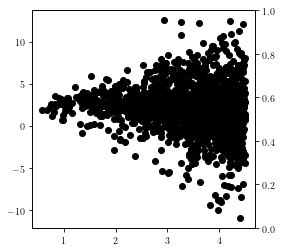

In [457]:
    sarr=np.loadtxt('%s/myfile.txt'%path)
df=pd.DataFrame(np.c_[sarr],columns=['r','s','phi','phip','phipp'])
df.sort_values(by='r',inplace=True)
#df=df.sample(n=100)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax2=ax.twinx()

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
#ax.set_yscale('log')
#ax2.set_yscale('log')
#rij=xx #[:,0]

# df['phip'] = df['r']*df['r']
# df['phipp'] = 2*df['r']
ax.plot(df['r'],df['phi'],'o',color='black')
#ax2.plot(df['r'],df['phipp'],'o',color='red')

# y0=17.5
# phip=y0+df['phipp'].cumsum()[:-1]*np.diff(df['r'])
# ax.plot(df['r'][:-1],phip,'-',color='black')
# ax.plot(df['r'],df['phip'],'o')
#ax.plot(df['r'],np.gradient(df['phi'],df['r']),'-')

#ax2.plot(rij,-np.gradient(cikj,rij),'ro')
#ax2.plot(rij,-dCikj*rij,'-')

#ax2.plot(rij,np.gradient(np.gradient(cikj,rij),rij),'ro')
#ax2.plot(rij,ddCikj,'-')

#ax2.plot(rij,ddfcij,'o')
plt.show()

In [405]:
xlim=ax.axis()[:2]
ylim=ax.axis()[2:]

In [452]:
n=1000
lx=50
#sarr=np.c_[np.arange(1,n+1,dtype=int),np.ones(n,dtype=int)*2,np.linspace(0,lx,n),np.zeros(n),np.zeros(n)]
sarr=np.c_[np.arange(1,n+1,dtype=int),np.ones(n,dtype=int)*2,np.random.random(n)*lx,np.random.random(n)*lx,np.random.random(n)*lx]
sfile=open('data.txt','w')
for item in sarr:
    print >> sfile, int(item[0]),int(item[1]),item[2],item[3],item[4]
sfile.close()
          
           
           

## PDF

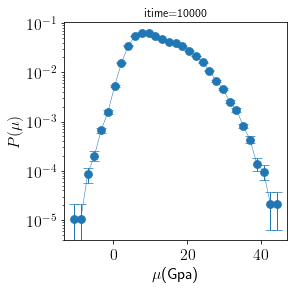

In [32]:
def GetPDF(slist, n_per_decade=4, ACCUM = None, linscale = None):
    if not linscale:
        xlo = np.floor(np.log10(np.min(slist)))
        xhi = np.ceil(np.log10(np.max(slist)))
        bins = np.logspace(xlo,xhi,int(xhi-xlo)*n_per_decade)    
    else:
        xlo = np.min(slist)
        xhi = np.max(slist)
        bins = np.linspace(xlo,xhi,n_per_decade)
        
    hist, edges = np.histogram(slist,bins=bins,density=True)
    count, edges = np.histogram(slist,bins=bins)
    
    
    if ACCUM:
        return np.cumsum((edges[1:]-edges[:-1])*hist), edges
    
    
    hist = hist[count>0]
    edges = edges[:-1][count>0]
    count = count[count>0]
    
    return  hist, edges, hist / count**0.5



#--- size distribution
itime = ITIME = np.max(coord_atoms_broken.keys()) #rand.sample(coord_atoms_broken.keys(),1)[0]
value = np.c_[coord_atoms_broken[itime][muColmn]].astype(float)*1e-6
hist, edges2, error = GetPDF( value, linscale = True, n_per_decade=32)

#--- plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim(1e-10,1e-4)
ax.set_xlabel(r'$\mu$(Gpa)',fontsize=16)
ax.set_ylabel(r'$P(\mu)$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title(r'itime=%s'%itime)
#
ax.errorbar(edges2,hist,error,fmt='-o',
            markersize=8,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1)
#
plt.savefig('muPDF.png',dpi=75,bbox_inches='tight')
plt.show()

### make a fit

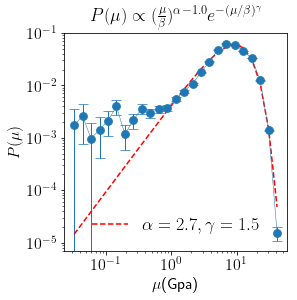

In [88]:
from scipy.optimize import curve_fit

def func(x,alpha,beta):
    return (alpha/beta)*(x/beta)**(alpha-1.0)*np.exp(-(x/beta)**alpha)

def func2(x,alpha0,alpha1,beta,c):
    return c*(x/beta)**(alpha0-1.0)*np.exp(-(x/beta)**alpha1)

value = np.c_[coord_atoms_broken[itime][muColmn]].astype(float)*1e-6
value = value[value>0]
hist, edges2, error = GetPDF( value, linscale = False, n_per_decade=8)

#--- fit
rc = 0.8
hist_filt=hist[edges2>rc]
error_filt=error[edges2>rc]
edges2_filt=edges2[edges2>rc]
popt0, pcov = curve_fit(func2, edges2_filt, hist_filt, 
#                       p0=(1.0,20.0),
                       p0=(1.0,1.0,20.0,1.0),
                       sigma=error_filt,
 #                      bounds=((1.0,0.0), (6.0,100.0))
                       )

#--- plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(1e-10,1e-4)
ax.set_xlabel(r'$\mu$(Gpa)',fontsize=16)
ax.set_ylabel(r'$P(\mu)$',fontsize=16)
ax.tick_params(labelsize=16)
#
ax.errorbar(edges2,hist,error,fmt='-o',
            markersize=8,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1)
ax.plot(edges2,func2(edges2,*popt0),'--r',label=r'$\alpha=%2.1f,\gamma=%2.1f$'%(popt0[0],popt0[1]))
#
xstr = r'$P(\mu)\propto(\frac{\mu}{\beta})^{\alpha-1.0} e^{-(\mu/\beta)^\gamma}$' 
ax.set_title(xstr,fontsize=18)
ax.legend(frameon=False, fontsize=18)
#
plt.savefig('muPDFfit.png',dpi=75,bbox_inches='tight')
plt.show()

### log-normal distribution

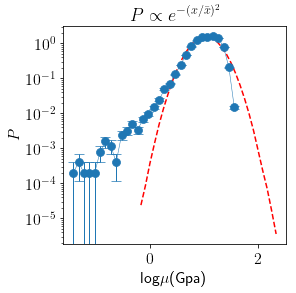

In [92]:
#--- size distribution
itime = ITIME = np.max(coord_atoms_broken.keys()) #rand.sample(coord_atoms_broken.keys(),1)[0]
#
value = np.c_[coord_atoms_broken[itime][muColmn]].astype(float)*1e-6
value = value[ value > 0.0 ]
value = np.log10( value )
hist, edges2, error = GetPDF( value, linscale = True, n_per_decade=32)

#--- fit a gaussian
value = np.random.normal(loc=np.mean(value), scale=np.std(value), size=10000000)
hist_g, edges2_g, error_g = GetPDF( value, linscale = True, n_per_decade=32)

#--- plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim(1e-10,1e-4)
ax.set_xlabel(r'log$\mu$(Gpa)',fontsize=16)
ax.set_ylabel(r'$P$',fontsize=16)
ax.tick_params(labelsize=16)
xstr = r'$P\propto e^{-(x/\bar{x})^2}$' 
ax.set_title(xstr,fontsize=18)
#
ax.errorbar(edges2,hist,error,fmt='-o',
            markersize=8,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1)
ax.plot(edges2_g,hist_g,'--r',)
#
plt.savefig('muPDFGauss.png',dpi=75,bbox_inches='tight')
plt.show()

## Interpolation


### mapping & add copies

In [54]:
def ChangeBasis( coord_atoms_broken, CellVector, CellOrigin ): #, **kwargs ):
############################################################
####### map atoms within a tilted box to an orthogonal one
############################################################
    assert type(coord_atoms_broken) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    DimensionlessCords = GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin  ) #--- beta0, beta1, beta2

    #--- shift (beta0 + beta1 * dx / |b0| > 1) by - b0
    #--- [b0,b1]^{-1}*(x=|b0|,y)
    
    b2 = CellVector[:,2]
    b1 = CellVector[:,1]
    b0 = CellVector[:,0]
    norm_b0 = np.dot(b0,b0)**0.5
    shift0 = np.dot(b1, b0 / norm_b0 )
    #
    beta0 = DimensionlessCords[:,0]
    beta1 = DimensionlessCords[:,1]
    indices_shiftTrue = (beta0) + (beta1)*shift0/norm_b0 >= 1.0
    n = len( indices_shiftTrue )
    shift_matrix =  np.array(indices_shiftTrue).reshape((n,1)) * b0
    #
    xyz = coord_atoms_broken - shift_matrix
    #
    return xyz 
#
def AddCopies( coord_atoms_broken, CellVector, CellOrigin, 
               **kwargs ):    
############################################################
####### add replicals of the center simulation box
############################################################
    assert type(coord_atoms_broken) == type(pd.DataFrame())
    
    assert type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    #--- orignial cell
    XYZ_shifted = np.c_[coord_atoms_broken]
    xyz_original = XYZ_shifted.copy()
    #--- add other attributes to xyz 
    attr_list = list(coord_atoms_broken.keys()) 

#     #--- exclude xyz
    df = pd.DataFrame(kwargs)
    ID_TYPE_shifted = np.c_[df] #values[:,3:]
    id_type_original = ID_TYPE_shifted.copy()
    
    #--- cell copies
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            for k in [-1,0,1]:
    #            print i,j,k
                if i == j == k == 0:
                    continue
                total_shift = np.matmul( CellVector, np.array([i,j,k]) ) #--- shape (3,)
                total_shift = np.concatenate([total_shift,total_shift, total_shift],axis=0) #--- shape: (6,)
                assert total_shift.shape[ 0 ] == 9
                #--- add shift
                xyz_shifted = xyz_original + total_shift
                #--- append
                XYZ_shifted = np.concatenate( ( XYZ_shifted, xyz_shifted ), axis = 0 )
                ID_TYPE_shifted = np.concatenate( ( ID_TYPE_shifted, id_type_original ), axis = 0 )
                                
    return pd.DataFrame(np.c_[XYZ_shifted,ID_TYPE_shifted],columns=attr_list + list(df.keys()))
#
def GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin): #, **kwargs  ):
############################################################
####### compute dimensionless coords of atoms given 
####### corresponding cartesian coords
############################################################
    assert type(coord_atoms_broken) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    xyz_centered = coord_atoms_broken - CellOrigin
    beta = np.matmul( np.linalg.inv(CellVector), xyz_centered.T).T
    
        
    return beta 

def shiftBeta( xyzDimensionless_j, diff ):
    indices = diff > 0.5
    beta0_j = xyzDimensionless_j - 1.0 * indices

    indices = diff < -0.5
    beta0_j += 1.0 * indices
    
    return beta0_j
#
def GetXYZ( CellVector, CellOrigin, DimensionlessCords ): #, attr_list = ['x','y','z'], **kwargs ):
############################################################
####### compute coords of atoms given 
####### corresponding dimensionless coords
############################################################
    assert type(DimensionlessCords) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    
    XYZ_centered = np.matmul( CellVector, DimensionlessCords.T ).T #--- xyz in reference state
    XYZ = XYZ_centered + CellOrigin
    
        
    return XYZ 
#
def MapCoord( coord_atoms_broken,
              KEYS,
              **kwargs
            ):
############################################################
##### map coords and add images of atoms and 
##### relevant attributes
############################################################
    coord = {}
    for itime in KEYS:
        #--- map atoms in the ref. state to an undeformed box
        df = coord_atoms_broken[ itime ]
        xyz = np.c_[df[['x','y','z']].astype('float')]
        xyz_mapped = ChangeBasis( xyz, CellVector[ itime ], CellOrigin[ itime ] )

        #--- append ['xm','ym','zm']
        #--- column list
        AddColumns = ['xm','ym','zm'] if  not 'AddColumns' in kwargs else kwargs['AddColumns']
        if not isSane( AddColumns, df.keys() ):
            return
        
        columns = list(df.keys())+ AddColumns
        coord[itime] = pd.DataFrame(np.c_[df, xyz_mapped],columns=columns)


    return coord 
#    
def to_dict( df ):
    sdict = {}
    skeys = df.keys().to_list()
    for ikey in skeys:
        sdict[ikey] = df[ikey].to_list()

    return sdict
#
def GetCopies( coord_atoms_broken,
               CellVector,
               CellOrigin,
               KEYS,
               ev = 0.1,
               columns_r = ['x','y','z'],
               columns_rm = ['xm','ym','zm'] #--- transform these coulmns
             ):
############################################################
####### add replicals of the center simulation box
############################################################
    
    columns = columns_r + columns_rm
    assert len( columns ) == 9
    for itime in KEYS:
        df = coord_atoms_broken[ itime ].copy()
        #
        xyz = np.c_[df[columns].astype('float')] #--- store 'xyz','xm'
        #--- store other columns in a dict. and pass as a kwrd arg.
        for item in columns: #--- pop 'xyz'
            df.pop( item )
        sdict = to_dict(df) #--- store in a dic. 
        #---
        xyz_copy = AddCopies( pd.DataFrame(xyz, columns=columns), CellVector[ itime ], CellOrigin[itime],
                              **sdict
                            )
        #--- print mapped xyz
#         PrintOvito( xyz_copy, 
#                     open( 'xyz_copy.xyz','w'), 
#                     footer = 'ITIME=%s'%itime,
#                     attr_list=['id','type','xm','ym','zm'] )

        #--- exclude atoms in the replicas which are out of the expanded box
        if ev == 1.0:
            indices = len(xyz_copy) * [True] #--- full copies
        else:
            indices =  isInsideExpanded( CellOrigin[ itime ], 
                                       CellVector[ itime ],
                                       np.c_[xyz_copy[columns_rm]], #--- give mapped coordinates
                                       ev = ev,
                                     )
        coord_atoms_broken[itime] = xyz_copy[ indices ]

def isInsideExpanded( CellOrigin, CellVector, xyz, ev = 0.2):
############################################################
####### Get atoms inside an expanded box
############################################################    
    assert type(xyz) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

#
#--- tensor associated with dilation
    strainTensor = np.array([[ev/3.0,0,0],
                            [0,ev/3.0,0],
                            [0,0,ev/3.0]])
    #
    identityMat = np.array([[1,0,0],[0,1,0],[0,0,1]])
    #
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )

    #--- extend diagonal
    rvect = -np.matmul( CellVectorOrtho, np.array([0.5,0.5,0.5]))
    CellOrigin_expanded = CellOrigin + np.matmul(strainTensor,rvect)

    #--- extend basis vectors
    CellVector_expanded = np.matmul( identityMat + strainTensor, CellVectorOrtho )

    return isInside( CellOrigin_expanded, CellVector_expanded, 
                     xyz )


def isInside( CellOrigin, CellVector, xyz ):
    assert type(xyz) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    DimensionlessCords = GetDimensionlessCords( CellVector, 
                                                xyz,
                                                CellOrigin,
                                              )
    #--- filter: only inside the expanded box 
    beta0 = DimensionlessCords[:,0]
    beta1 = DimensionlessCords[:,1]
    beta2 = DimensionlessCords[:,2]
    index0 = np.all([beta0 >= 0.0, beta0 < 1.0], axis=0 )
    index1 = np.all([beta1 >= 0.0, beta1 < 1.0], axis=0 )
    index2 = np.all([beta2 >= 0.0, beta2 < 1.0], axis=0 )
    
    return np.all([index0,index1,index2],axis=0)   



def EstimateUnwrappedCord( coord_atoms_broken_i, coord_atoms_broken_j,
                           CellVector_i, CellVector_j,
                           CellOrigin_i, CellOrigin_j):
    
    assert type(coord_atoms_broken_i) == type( coord_atoms_broken_j ) ==\
           type( CellVector_i ) == type( CellVector_j ) ==\
           type( CellOrigin_i ) == type( CellOrigin_j ) == type(np.array([]))

    
    #--- dimensionless cords
    xyzDimensionless_i = GetDimensionlessCords( CellVector_i, coord_atoms_broken_i, CellOrigin_i )
    xyzDimensionless_j = GetDimensionlessCords( CellVector_j, coord_atoms_broken_j, CellOrigin_j )

    #--- shift to get unwrapped cords
    diff = xyzDimensionless_j - xyzDimensionless_i

    #--- new dimensionless cords
    beta0_j = shiftBeta( xyzDimensionless_j[:,0], diff[:,0])
    beta1_j = shiftBeta( xyzDimensionless_j[:,1], diff[:,1])
    beta2_j = shiftBeta( xyzDimensionless_j[:,2], diff[:,2])

    #--- unwrapped cords at deformed state
    rj_unwrpd = GetXYZ( CellVector_j, CellOrigin_j, np.c_[beta0_j,beta1_j,beta2_j] )

    return rj_unwrpd

def isSane( AddColumns, columnList ):
    #--- avoid duplicates
    assert len( set( AddColumns ) ) == len( AddColumns ), 'duplicates in the list!'
    #--- assert column list is not already included
    n = len( AddColumns )
    AddColumns = list( set(AddColumns) - set( columnList ) )
    if len(AddColumns) != n:
        print 'column already included!'
        return False
    return True
    
    
def GetDipl( coord,
        CellVector, CellOrigin,
        KEYS = [0],
        **kwargs
        ):

    times = KEYS 
    times.sort()
    
    time_pairs = [(0,0)]+zip(times[:-1], times[1:])
    for time_i, time_j in time_pairs:   
    #    print time_i, time_j
        #--- estimate unwrapped coordinates (deformed state)
        # r^{wrpd}_i, r^{wrpd}_j, r^{unwrpd}_j
        xyz_i = np.c_[coord[time_i][['x','y','z']]].astype('float')
        xyz_j = np.c_[coord[time_j][['x','y','z']]].astype('float')
        rj_unwrpd = EstimateUnwrappedCord( xyz_i, xyz_j,
                                           CellVector[time_i], CellVector[time_j],
                                           CellOrigin[time_i], CellOrigin[time_j] )    
        #--- displacement: r^{unwrpd}_j - r^{wrpd}_i
        disp = rj_unwrpd - xyz_i
        #--- 
        
        #--- append (xm,ym,zm) denoting mapped coordinates
        ikey = time_j #if REF == 'initial' else time_i
        df = coord[ ikey ]
        #--- column list
        AddColumns = ['ux','uy','uz'] if  not 'AddColumns' in kwargs else kwargs['AddColumns']
        if not isSane( AddColumns, df.keys() ):
            return
        #--- append
        columns = list(df.keys()) + AddColumns
        
        coord[ ikey ] = pd.DataFrame(np.c_[df, disp],columns = columns )

def GetDiplUnwrapped( coord,
        CellVector, CellOrigin,
        KEYS = [0],
        **kwargs
        ):

    times = KEYS 
    times.sort()
    
    time_pairs = [(0,0)]+zip(times[:-1], times[1:])
    for time_i, time_j in time_pairs:   
    #    print time_i, time_j
        #--- estimate unwrapped coordinates (deformed state)
        # r^{wrpd}_i, r^{wrpd}_j, r^{unwrpd}_j
        xyz_i = np.c_[coord[time_i][['xu','yu','zu']]].astype('float')
        xyz_j = np.c_[coord[time_j][['xu','yu','zu']]].astype('float')
       #--- displacement: r^{unwrpd}_j - r^{wrpd}_i
        disp = xyz_j - xyz_i
        #--- 
        
        #--- append (xm,ym,zm) denoting mapped coordinates
        ikey = time_j #if REF == 'initial' else time_i
        df = coord[ ikey ]
        #--- column list
        AddColumns = ['ux','uy','uz'] if  not 'AddColumns' in kwargs else kwargs['AddColumns']
        if not isSane( AddColumns, df.keys() ):
            return
        #--- append
        columns = list(df.keys()) + AddColumns
        
        coord[ ikey ] = pd.DataFrame(np.c_[df, disp],columns = columns )
        
def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()
    
def Wrap( CellOrigin, CellVector, xyz ):
############################################################
####### Wrap atom positions 
############################################################    
    assert type(xyz) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    
    DimensionlessCords = GetDimensionlessCords( CellVector, 
                                                xyz,
                                                CellOrigin,
                                              )
    
    DimensionlessCords = DimensionlessCords % 1.0
    
    XYZ = GetXYZ( CellVector, CellOrigin, DimensionlessCords )
    
    indices = isInside( CellOrigin, CellVector, XYZ )
    
    assert len( XYZ[ indices ] ) == len( XYZ ), 'not all atoms are inside!'
    
    return XYZ



def WrapDataFrame( coord_atoms_broken, 
                   CellOrigin, CellVector,
                   KEYS,
                   columns = ['x','y','z']):
    
    for itime in KEYS:
        df = coord_atoms_broken[ itime ].copy()
        xyz = np.c_[df[columns]].astype(float)
        xyz_wrapped = Wrap(CellOrigin[ itime ], CellVector[ itime ], xyz)
        #--- replace associated columns
        for item in columns:
            df.pop( item )
        columns2 = list(df.keys())+columns
        coord_atoms_broken[ itime ] = pd.DataFrame(np.c_[df,xyz_wrapped],columns = columns2 )
        


# ITIME = 300
# JTIME = 600
#--- wrap coordintaes (don't trust lammps!)
WrapDataFrame(coord_atoms_broken, 
              CellOrigin, CellVector,
              KEYS = coord_atoms_broken.keys(), #[0,ITIME],#,
              columns = ['x','y','z']
              )

#--- print actual xyz
# PrintOvito( coord_atoms_broken[ ITIME ], 
#              open( 'xyz_actual.xyz','w'), 
#              footer = 'ITIME=%s'%ITIME,
#              attr_list=['id','type','x','y','z','ux','uy','uz'] )

#--- map to the squared cell    : add columns = ['xm','ym','zm']
coord = MapCoord( coord_atoms_broken,
                  KEYS = coord_atoms_broken.keys(),#[0,ITIME],#
                  AddColumns = ['xm','ym','zm']
                )

#--- print mapped xyz
# PrintOvito( coord[ ITIME ], 
#             open( 'xyz_mapped.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['id','type','xm','ym','zm','ux','uy','uz'] )

#--- add replicas
GetCopies( coord,
           CellVector,
           CellOrigin,
           KEYS = coord.keys(), #[0,ITIME],#[ITIME]
           ev = 1.0, #--- don't change this! need a full copy to compute displ.
           columns_r = ['x','y','z','xu','yu','zu'],
           columns_rm = ['xm','ym','zm'] #--- transform these two sets of columns
         )

#--- compute displacements: x_{i+1}-x_i, add columns = ['ux','uy','uz']
GetDiplUnwrapped(    coord,
                     CellVector, CellOrigin,
                     KEYS = coord.keys(), #[0,ITIME],#,
                     AddColumns = ['ux','uy','uz']
                )        

# #--- print mapped xyz
# PrintOvito( coord[ ITIME ], 
#             open( 'xyz_expanded.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['id','type','xm','ym','zm','ux','uy','uz'] )




In [55]:
def IntegrateColumnInTime( coord, col, colnew ): 
    
    if not isSane( [colnew], coord[ 0 ].keys() ):
        return
    
    times = coord.keys()
    times.sort()
    xsum = np.zeros( len( coord[ 0 ] ) )
    for itime in times:
        xsum += coord[ itime ][ col ]
        coord[ itime ][ colnew ] = xsum.copy()

#--- integrate U=\sum_{itime=0}u_{itime}
IntegrateColumnInTime( coord, 'ux', 'Ux' )
IntegrateColumnInTime( coord, 'uy', 'Uy' )
IntegrateColumnInTime( coord, 'uz', 'Uz' )

In [56]:
# #--- print mapped xyz
# PrintOvito( coord[ ITIME ], 
#              open( 'xyz_expanded.xyz','w'), 
#              footer = 'ITIME=%s'%ITIME,
#              attr_list=['id','type','xu','yu','zu','Ux','Uy','Uz'] )

In [57]:
# #--- assert displacements are additive

# cords = {}
# cords[ITIME] = coord[ITIME].copy()
# cords[0] = coord[0].copy()
# for ikey in ['ux','uy','uz','Ux','Uy','Uz']:
#     cords[ITIME].pop(ikey)
#     cords[0].pop(ikey)

# GetDiplUnwrapped( cords,
#          CellVector, CellOrigin,
#          KEYS = cords.keys(), #[0,ITIME],#,
#          AddColumns = ['ux','uy','uz']
#        )  
# #--- integrate U=\sum_{itime=0}u_{itime}
# IntegrateColumnInTime( cords, 'ux', 'Ux' )
# IntegrateColumnInTime( cords, 'uy', 'Uy' )
# IntegrateColumnInTime( cords, 'uz', 'Uz' )

# hist, edges = np.histogram(cords[ITIME]['Ux']-coord[ITIME]['Ux'],bins=32)
# #hist2, edges2 = np.histogram(,bins=32)
# plt.yscale('log')
# plt.plot(edges[:-1],hist,'o')
# #plt.plot(edges2[:-1],hist2,'s',color='red')
# plt.show()

Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


KeyboardInterrupt: 

### cubic grid

In [58]:
def GetCubicGrid( CellOrigin, CellVector, dmean, margin  ):

    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    
    volume = np.linalg.det( CellVectorOrtho )


    [nx, ny, nz] = map( int, (np.array(VectorNorm)+2*margin) / dmean )
    if nx%2 == 0:
        nx += 1
    if ny%2 == 0:
        ny += 1
    if nz%2 == 0:
        nz += 1
    
    x = np.linspace( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin, nx,endpoint=False)
    y = np.linspace( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin, ny,endpoint=False)
    z = np.linspace( CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin, nz,endpoint=False)

    return (x, y, z), np.meshgrid(x, y,z)



#--- mean dist between atoms 
natoms = len( coord_atoms_broken[ 0 ] ) 
CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ 0 ] )
volume = np.linalg.det( CellVectorOrtho )
dmean = ( volume / natoms ) ** (1.0/3.0)
print 'dmean=%s'%dmean

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = GetCubicGrid( CellOrigin[ 0 ], 
                                                 CellVector[ 0 ], 
                                                 dmean,
                                                 margin = 0.0 * dmean )
xi = np.array(zip(xv.flatten(), yv.flatten(), zv.flatten()))
print xlin.shape, ylin.shape, zlin.shape

dmean=2.287993253406484
(35,) (39,) (39,)


### linear intrp: center box + margin

In [59]:
def isKeyInDataFrame(values_column, df):
    trueFalse = [key in df.keys() for key in values_column]
    return np.all(trueFalse)

def Intrp( coord,
           grid,
           CellOrigin, CellVector,
           keys = [],
           ev = 0.0,
           points_column = [],
           values_column = [],
         ):
    
    #--- linear interpolation
    df_intrp = {}
    keys.sort()
    assert keys[ 0 ] == 0, 'keys must contain itime = 0!'
    for itime in keys:
        #--- get a chunck of full copies
        df_i = coord[ 0 ]
        df_j = coord[ itime ]

        if itime == 0:
            indices =  isInsideExpanded(   CellOrigin[ itime ], 
                                           CellVector[ itime ],
                                           np.c_[df_i[points_column]], #--- give mapped coordinates
                                           ev = ev,
                                       )
        
        #--- assert columns are included in the df
        if not( isKeyInDataFrame(values_column, df_i) and isKeyInDataFrame(points_column, df_i) ):
            continue
        
        #--- interpolate
        points = df_i[indices][ points_column ]
        values = df_j[indices][ values_column ]
        xi = grid
        grid_z = scp_int.griddata(points, values, xi, method='linear')
        assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'


    #     x, y, z, d = np.c_[pointsValues[['xm','ym','zm','mu']].iloc[:-1]].T
    #     rbfi = Rbf(x.tolist(), y.tolist(), z.tolist(), d.tolist(), function = 'gaussian', epsilon = dmean)  # radial basis function interpolator instance
    #     grid_z = rbfi(xv, yv, zv).flatten()   # interpolated values

        #--- store in dataframe
        df_intrp[ itime ] = pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z']+values_column)
    return df_intrp


df_intrp = Intrp( coord,
                 xi,
                 CellOrigin, CellVector,
                 keys = coord.keys(),
                 ev = 0.3, 
                 points_column = ['xm','ym','zm'],
                 values_column = ['c_1[22]', 'ux', 'uy', 'uz', 'Ux', 'Uy', 'Uz' ],
               )



In [49]:
# df_intrp = Intrp( cords,
#                  xi,
#                  CellOrigin, CellVector,
#                  keys = cords.keys(),
#                  ev = 0.3, 
#                  points_column = ['xm','ym','zm'],
#                  values_column = ['c_1[22]', 'ux', 'uy', 'uz', 'Ux', 'Uy', 'Uz' ],
#                )

In [46]:
# #--- print mapped xyz
# PrintOvito( df_intrpp[ITIME], 
#             open( 'xyz_expanded0.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['x','y','z','Ux','Uy','Uz'] )

# PrintOvito( df_intrp[ITIME], 
#             open( 'xyz_expanded1.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['x','y','z','Ux','Uy','Uz'] )

### Strain tensor

In [61]:
def GetStrain( value, (xlin,ylin,zlin), (xv,yv,zv)):
    #--- reshape matrix
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    ux = value[:,0].reshape((ny,nx,nz))
    uy = value[:,1].reshape((ny,nx,nz))
    uz = value[:,2].reshape((ny,nx,nz))

    #--- gradient
    ux_x = np.gradient(ux,xlin,axis=1)
    ux_y = np.gradient(ux,ylin,axis=0)
    ux_z = np.gradient(ux,zlin,axis=2)

    uy_x = np.gradient(uy,xlin,axis=1)
    uy_y = np.gradient(uy,ylin,axis=0)
    uy_z = np.gradient(uy,zlin,axis=2)

    uz_x = np.gradient(uz,xlin,axis=1)
    uz_y = np.gradient(uz,ylin,axis=0)
    uz_z = np.gradient(uz,zlin,axis=2)

    #--- strain
    exx = ux_x
    exy = 0.5 * ( ux_y + uy_x )
    exz = 0.5 * ( ux_z + uz_x )

    eyx = exy
    eyy = uy_y
    eyz = 0.5 * ( uy_z + uz_y )

    ezx = exz
    ezy = eyz
    ezz = uz_z
    
    #--- subtract mean
    exx -= np.mean(exx)
    exy -= np.mean(exy)
    exz -= np.mean(exz)

    eyx -= np.mean(eyx)
    eyy -= np.mean(eyy)
    eyz -= np.mean(eyz)

    ezx -= np.mean(ezx)
    ezy -= np.mean(ezy)
    ezz -= np.mean(ezz)
    
    return np.c_[
                 exx.flatten(), eyy.flatten(), ezz.flatten(), 
                 exy.flatten(), eyz.flatten(), ezx.flatten()]


for itime in df_intrp:
    df = df_intrp[ itime ]
    #--- compute strain
    Strain = GetStrain(np.c_[df[['ux','uy','uz']]], 
                              (xlin,ylin,zlin), (xv,yv,zv))
    #--- append to data frame
    AddColumns = ['exx','eyy','ezz','exy','eyz','ezx']
    if isSane( AddColumns, df.keys() ):
        df_intrp[ itime ] = pd.DataFrame(np.c_[df,Strain], 
                                         columns = list(df.keys())+ AddColumns
                                        )
    #--- Accumulated strain
    df = df_intrp[ itime ]
    Strain = GetStrain(np.c_[df[['Ux','Uy','Uz']]], 
                              (xlin,ylin,zlin), (xv,yv,zv))
    #--- append to data frame
    AddColumns = ['Exx','Eyy','Ezz','Exy','Eyz','Ezx']
    if isSane( AddColumns, df.keys() ):
        df_intrp[ itime ] = pd.DataFrame(np.c_[df,Strain], 
                                         columns = list(df.keys())+ AddColumns
                                        )
    #--- change column name
    df_intrp[ itime ].rename(index=str, columns={"c_1[22]": "mu"}, inplace=True)


### Print

In [92]:
file_name = 'strain.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass
    
times = df_intrp.keys()
times.sort()
for itime in times:
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1

    
    PrintOvito( df_intrp[ itime ], 
                    open( file_name,'a'), 
                    footer = 'epsilon=%2.1e'%(2*ebulk),
                    attr_list=['x','y','z','mu', 'exy', 'Exy'] ) #'exx','eyy','ezz','exy','eyz','ezx'] )
    

### imshow

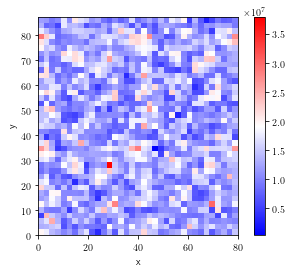

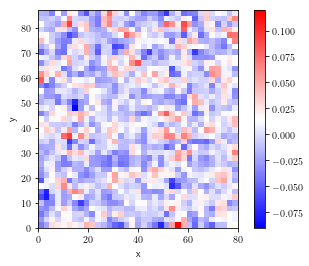

In [62]:
def FilterMatrix( CellVector, CellOrigin,
                  (xlin, ylin, zlin),
                  (xv, yv, zv ),
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>xlo,xv<xhi, yv>ylo,yv<yhi, zv>zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[ a[i,j] for j in xrange(-(ngrid/2),ngrid/2+ngrid%2)] 
                              for i in xrange(-(mgrid/2),mgrid/2+mgrid%2)])

def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'fig.png',
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
#         val[val>2.0]=1.0
#         val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
#    plt.xlim(center[0]-(ngrid/2)*frac,center[0]+(ngrid/2)*frac)
#    plt.ylim(center[1]-(mgrid/2)*frac,center[1]+(mgrid/2)*frac)
#    plt.xlim(xlim[0]*frac,xlim[1]*frac)
#    plt.ylim(ylim[0]*frac,ylim[1]*frac)
    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(title,dpi=75,bbox_inches='tight')
    plt.show()


itime = ITIME
for col in ['mu', 'Exy']:

    #--- reshape value
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    value = np.c_[df_intrp[itime][col]].reshape(((ny,nx,nz)))

    #--- filter value
#     value = FilterMatrix( CellVector[0], CellOrigin[0],
#                       (xlin, ylin, zlin),
#                       (xv, yv, zv ),
#                        value )

    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
    #--- xy plane
    val = value[:,:,-1].copy()

    PltBitmap(val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = False,
              frac = 1.0, #--- plot a patch
              title = col,
            )

### Correlations

#### scatter plot (mu-exy)

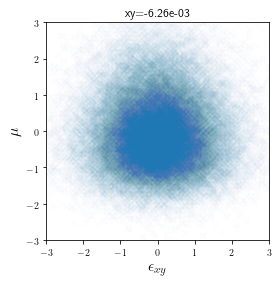

In [212]:
def zscore( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )
    return value

itime = ITIME
#
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\epsilon_{xy}$',fontsize=16)
ax.set_ylabel(r'$\mu$',fontsize=16)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
#
x = zscore(np.array(df_intrp[itime]['Exy'].to_list()))
y = zscore(np.array(df_intrp[itime]['mu'].to_list()))
ax.scatter(x,y,marker='x',color='C0',alpha=0.01)
#
ax.set_title('xy=%3.2e'%(np.sum(x*y)/len(x)))
#
plt.savefig('mu_exy_crltn.png',dpi=75,bbox_inches='tight')
plt.show()

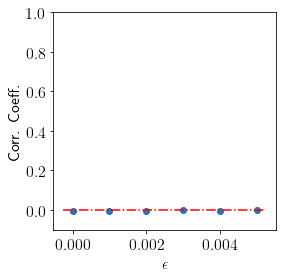

In [42]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'Corr. Coeff.',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_ylim(-0.1,1.0)
#
for itime in df_intrp:
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] )
    #--- strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    strain = 0.5*dx/l1                
    #
    x = zscore(np.array(df_intrp[itime]['exy'].to_list()))
    X = zscore(np.array(df_intrp[itime]['Exy'].to_list()))
    y = zscore(np.array(df_intrp[itime]['mu'].to_list()))
    crltn = np.sum(x*y)/len(x)
    crltn2 = np.sum(X*y)/len(X)
    #
    ax.plot([2*strain],[crltn], '-o',color='C0')
    ax.plot([2*strain],[crltn2], '-s',color='red')

ax.plot(ax.axis()[:2],[0,0], '-.r',color='red')

plt.savefig('crltn_strain.png',dpi=75,bbox_inches='tight')
plt.show()

In [323]:
# def GetAutoCorrelation( val ):
#     value  = val.copy()
#     value -= np.mean( value )
#     value /= np.std( value )

#     ( nx, ny, nz ) =  value.shape
#     n = nx * ny * nz
#     vq = np.fft.fftn(value) #, axes=(0,1,2))
#     vq_sq = np.abs(vq)**2

#     v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
#     return v_real


# Crltn = {}
# for itime in mu_born:
#     #
#     (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
#     #
#     value = np.c_[mu_born[itime]['mu']].reshape(((ny,nx,nz)))
#     #
#     #--- filter value
# #     value = FilterMatrix( CellVector[0], CellOrigin[0],
# #                   (xlin, ylin, zlin),
# #                   (xv, yv, zv ),
# #                    value )

#     Crltn[ itime ] = GetAutoCorrelation( value )


In [325]:
def GetAutoCorrelation2d( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny ) =  value.shape
    n = nx * ny
    vq = np.fft.fft2(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifft2( vq_sq) / n #,  axes=(0,1,2) )
    return v_real



val = value[:,:,nz/2].copy()
Crltn = GetAutoCorrelation2d( val )


(0, 17) 0.2563218405143886


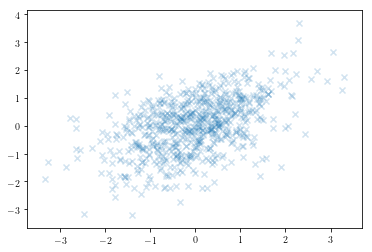

In [327]:
(m,n) = val.shape

rx=n/2
ry=0

value  = val.copy()
value -= np.mean( value )
value /= np.std( value )
    
xsum = 0.0
for i in xrange(m):
    for j in xrange(n):
        if (i+ry) >= m or (j+rx) >= n:
            continue
        xsum += value[i,j]*value[(i+ry),(j+rx)]
        plt.scatter([value[i,j].real],[value[(i+ry)%m,(j+rx)%n].real],marker='x',color='C0',alpha=0.2)
print (ry,rx), xsum / (m*n)

plt.show()

#### Print

In [307]:

# def PltCrltn( value,
#               xlabel = 'x', ylabel = 'y',
#               xlim = (-0.5,0.5), ylim = (-0.5,0.5),
#               frac = 1.0, #--- plot a patch
#               zscore = True,
#               fileName = 'cxy.png',
#               dpi=75,
#             ):
        
#     val = value.copy()
#     #--- zscore
#     if zscore:
#         val -= np.mean(val)
#         val /= np.std(val)
#         val[val>2.0]=1.0
#         val[val<-2.0]=-1.0
#     #
#     (mgrid,ngrid) = val.shape
#     center = (ngrid/2,mgrid/2)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
#                      extent=(xlim[0],xlim[1],ylim[0],ylim[1])) #,vmin=-.01, vmax=.01)
#     plt.xlim(xlim[0]*frac,xlim[1]*frac)
#     plt.ylim(ylim[0]*frac,ylim[1]*frac)

#     plt.colorbar( pos, fraction = 0.04)
#     plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
#     plt.show()


# for itime in Crltn:
#     print 'itime=',itime
#     CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
#     #    
#     crltn = Crltn[ itime ]
#     #--- xy plane
#     val = crltn[:,:,0].copy()
#     PltCrltn( val, 
#               xlabel = 'x', ylabel = 'y',
#               xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
#               frac = 1, #--- plot a patch
#               zscore = False,
#               fileName = 'cxy.%s.png'%itime,
#               dpi = 60
#             )
#     # #--- zx plane
#     # val = crltn[0,:,:].copy()
#     # PltCrltn( val, 
#     #           xlabel = 'z', ylabel = 'x',
#     #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
#     #           frac = 1.0, #--- plot a patch
#     #           zscore = False,
#     #         )
#     # #--- zy plane
#     # val = crltn[:,0,:a].copy()
#     # PltCrltn( val, 
#     #           xlabel = 'z', ylabel = 'y',
#     #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
#     #           frac = 1.0, #--- plot a patch
#     #           zscore = False,
#     #         )



itime= 0


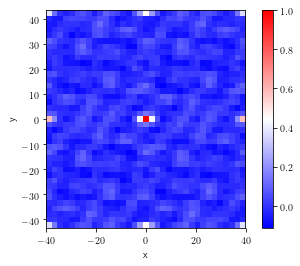

In [319]:

def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
        
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
#         val[val>2.0]=1.0
#         val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
#    pos = plt.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]))
    plt.xlim(xlim[0]*frac,xlim[1]*frac)
    plt.ylim(ylim[0]*frac,ylim[1]*frac)

    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()


    
for itime in [0]:
    print 'itime=',itime
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
    #    
    crltn = Crltn
    #--- xy plane
    val = crltn
    PltCrltn( val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 1, #--- plot a patch
              zscore = False,
              fileName = 'cxy.%s.png'%itime,
              dpi = 60
            )
    # #--- zx plane
    # val = crltn[0,:,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'x',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )
    # #--- zy plane
    # val = crltn[:,0,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'y',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )



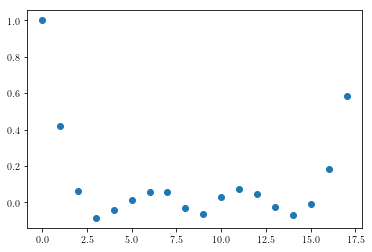

In [320]:
plt.plot(val[0,0:n/2+1],'o')
plt.show()

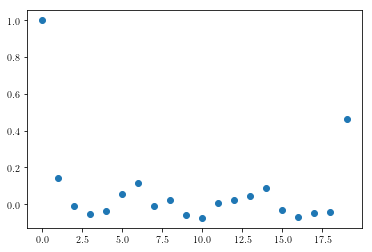

In [321]:
plt.plot(val[0:m/2+1,0],'o')
plt.show()

#### Crltn Length

In [70]:
def Get_rc( xdata, ydata, cTOL ):
    try:
        xc1 = xdata[np.abs(ydata)<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 (xv,yv),
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    xdata = np.arange(0,(n/2+n%2)) * dx
    ydata = val[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-o',label=r'$x$')       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    xdata = np.arange(0,(m/2+m%2)) * dy
    ydata = val[0:(m/2+m%2),0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-s', color = 'red',label=r'$y$')
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot((rc,rc),ax.axis()[2:],'-.r')
        #
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return (xc, yc)
    
    

for itime in Crltn:
    print 'itime=',itime
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1
    #---
    xc, yc = PltCrltnFunc( Crltn[ itime ], 
                 (xv,yv),
                 fileName = 'cr.%s.png'%itime,
                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    print xc, yc

itime= [ 1.        +0.00000000e+00j  0.2658274 +6.88618955e-18j
 -0.04848971-1.71179449e-17j -0.01102252-2.93916243e-17j
 -0.00884968-1.62750514e-17j  0.00918445-2.15780525e-17j
 -0.03312712-9.97251839e-18j -0.05288246-2.03756448e-17j
  0.00139661-1.38082397e-17j  0.01228676-1.68636758e-18j
 -0.03872604+8.73879645e-18j -0.06374491+1.27488594e-17j
 -0.06287136+1.78505217e-17j -0.07180323+1.72273930e-17j
 -0.0330112 +1.26224898e-17j -0.04694569+1.20088551e-17j
 -0.0283897 +9.51409139e-18j  0.38274144-1.22170903e-17j
  0.38274144+1.63072120e-17j -0.0283897 -1.87136875e-17j
 -0.04694569-1.20088551e-17j -0.0330112 -1.24391663e-17j
 -0.07180323-1.89805432e-17j -0.06287136-2.67810349e-17j
 -0.06374491-3.35037378e-18j -0.03872604-8.73879645e-18j
  0.01228676-1.12526459e-17j  0.00139661+2.79229491e-17j
 -0.05288246+1.96805331e-17j -0.03312712+1.81927031e-17j
  0.00918445+2.15780525e-17j -0.00884968+1.95271553e-17j
 -0.01102252+2.40585852e-17j -0.04848971+2.77042212e-17j
  0.2658274 -1.24691659e

TypeError: unhashable type: 'numpy.ndarray'

In [72]:
mean = coord_atoms_broken[itime]['c_1[22]'].astype(float).mean()
std = coord_atoms_broken[itime]['c_1[22]'].astype(float).std()
'%e'%(mean-2*std)

'-5.744436e+09'